fatal: destination path 'Articles' already exists and is not an empty directory.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


('BLEU score:', 0.065441643871883)


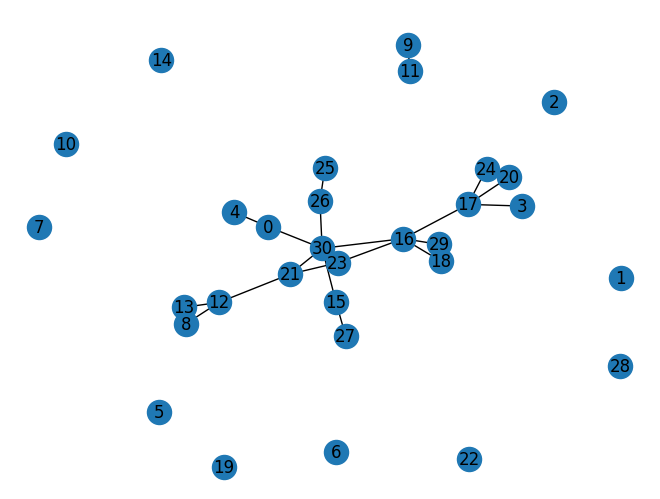

In [8]:
#All the articles used are downloaded from a GitHub repository when you run the program.

# Clone the articles used in the model from a github repository
!git clone https://github.com/MhlongoCB/Articles.git

# Preprocessing
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Weighted graph
import networkx as nx
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a pgn file to represent our graph
import matplotlib.pyplot as plt

# Bleu matric
from nltk.translate.bleu_score import corpus_bleu

# Regex
import re

# Open an article in read mode
with open('/content/Articles/Nature.txt', 'r') as file:
    # Read the entire contents of the article
    text = file.read()
    # Removes extra spaces
    text = re.sub(r'\s+', ' ', text)

# Tokenization
sentences = sent_tokenize(text)

# Preprocessing
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lem = WordNetLemmatizer()

def preprocess_word(word):
    if word in stop_words or word in punctuation:
        return None
    return lem.lemmatize(word,"v")

def preprocess_sentence(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence.lower())

    # Apply preprocessing to each word
    preprocessed_words = []
    for word in words:
        preprocessed_word = preprocess_word(word)
        if preprocessed_word is not None:
            preprocessed_words.append(preprocessed_word)

    # Join the preprocessed words back into a single string
    preprocessed_sentence = ' '.join(preprocessed_words)

    return preprocessed_sentence

# Preprocess sentences and create corpus
corpus = [preprocess_sentence(sentence) for sentence in sentences]

# Cosine similarity
def cosine_sim():
  # Calculate TF-IDF vectors
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Calculate cosine similarity
    cosine_sim = np.dot(tfidf_matrix, tfidf_matrix.T).toarray()
    return cosine_sim

  # Build graph
def graph():
  G = nx.Graph()

  # Add nodes
  for i, sentence in enumerate(sentences):
    G.add_node(i, sentence=sentence)

  # Add edges
  for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        sim = cosine_sim()[i][j]
        G.add_edge(i, j, weight=sim)
  return G

G = graph()

# Iterate through edges and remove weak ones
def threshold():
  threshold = 0.2
  for edge in list(G.edges(data=True)):
      if edge[2]['weight'] < threshold:
          G.remove_edge(edge[0], edge[1])
  return None

threshold()


plt.clf()
nx.draw(G, with_labels = True)
plt.savefig('AIGraph.png')

def page_rank():

  # Calculate PageRank scores
  pagerank_scores = nx.pagerank(G, weight='weight')

  # Sort nodes by PageRank score in descending order
  sorted_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

  top_sentences = sorted_nodes[:10]  # Select the top 10 sentences
  return top_sentences

# Bleu Matric
def bleu_matric():
    # Read hypotheses from file
  with open('/content/Articles/Nature summary human made.txt', 'r') as file:
      hypotheses = [line.strip().split() for line in file]

  # Read references from file
  with open('/content/Nature_textRank_summary.txt', 'r') as file:
      references = [[line.strip().split()] for line in file]

  bleu_score = corpus_bleu(references, hypotheses)

  return "BLEU score:", bleu_score

def main():
    with open('Nature_textRank_summary.txt', 'w') as file:
    # Write content to the file
      for i, (node_id, score) in enumerate(page_rank()):
        file.write(sentences[node_id])
    print(bleu_matric())

if __name__ == "__main__":
    main()